In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as f

  Using cached uproot-5.5.1-py3-none-any.whl.metadata (33 kB)
  Using cached awkward-2.7.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
  Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
Using cached uproot-5.5.1-py3-none-any.whl (362 kB)
Using cached awkward-2.7.3-py3-none-any.whl (868 kB)
Using cached awkward_cpp-44-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (638 kB)
Using cached cramjam-2.9.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.4 MB)


In [2]:
cheated_0 = Events('CheatedRecoFile_0.root')
sliced_0 = f.slice_events(cheated_0)
cheated_0_candidates = f.identify_candidate(cheated_0)

Events sliced, 499617 events split across 9505 unique event ids


In [3]:
''' Two features for step length '''

def step_length(events, event_idx):
    # find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]

    if len(w_hits) < 3:
        print(f'Warning: Event {event_idx} has only {len(w_hits)} hits.')

    if events.is_true_track[event_idx]:
        print('Warning: Event is a true track')

    # finding step length
    w_step = min([abs(w - w_vtx) for w in w_hits])
    x_step = min([abs(x - x_vtx) for x in x_hits])
    step_length = np.sqrt(w_step**2 + x_step**2)

    return step_length

def step_length_vtx(events, event_idx):
    nu_vtx_w = events.neutrino_vtx_w[event_idx]
    nu_vtx_x = events.neutrino_vtx_x[event_idx]
    vtx_w = events.reco_particle_vtx_w[event_idx]
    vtx_x = events.reco_particle_vtx_x[event_idx]

    w_step = abs(nu_vtx_w - vtx_w)
    x_step = abs(nu_vtx_x - vtx_x)
    return np.sqrt(w_step**2 + x_step**2)

def adc_step(events, event_idx):
    # find all info for the feature
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]
    w_vtx = events.neutrino_vtx_w[event_idx]
    x_vtx = events.neutrino_vtx_x[event_idx]
    adcs = np.array(events.reco_adcs_w[event_idx])
    adc_avg = np.mean(adcs)

    if len(w_hits) < 3:
        print(f'Warning: Event {event_idx} has only {len(w_hits)} hits.')

    if events.is_true_track[event_idx]:
        print('Warning: Event is a true track')

    # finding step length
    w_step = min([abs(w - w_vtx) for w in w_hits])
    x_step = min([abs(x - x_vtx) for x in x_hits])
    step_length = np.sqrt(w_step**2 + x_step**2)

    return step_length / adc_avg

In [4]:
''' Two arrays '''

# get all candidate idx - candidate asserted as being the largest hits of any event_number
testing_idx = [row[1] for row in cheated_0_candidates]

def step_arrays_2(events, hits_cutoff):
    n = len(events.num_final_state_particles)

    e_step = []
    gamma_step = []
    total_showers = 0

    for i in testing_idx:
        if len(events.reco_hits_w[i]) > hits_cutoff and not events.is_true_track[i]:
            step = step_length(events, i)
            total_showers += 1

            if events.mc_pdg[i] == 22:
                gamma_step.append(step)
            elif events.mc_pdg[i] in [-11, 11]:
                e_step.append(step)

    return e_step, gamma_step

e_2, gamma_2 = step_arrays_2(cheated_0, 15)

def adc_step_arrays(events, hits_cutoff):
    n = len(events.num_final_state_particles)

    e_step = []
    gamma_step = []
    total_showers = 0

    for i in testing_idx:
        if len(events.reco_hits_w[i]) > hits_cutoff and not events.is_true_track[i]:
            step = adc_step(events, i)
            total_showers += 1

            if events.mc_pdg[i] == 22:
                gamma_step.append(step)
            elif events.mc_pdg[i] in [-11, 11]:
                e_step.append(step)

    return e_step, gamma_step

e_adcstp, gamma_adcstp = adc_step_arrays(cheated_0, 15)

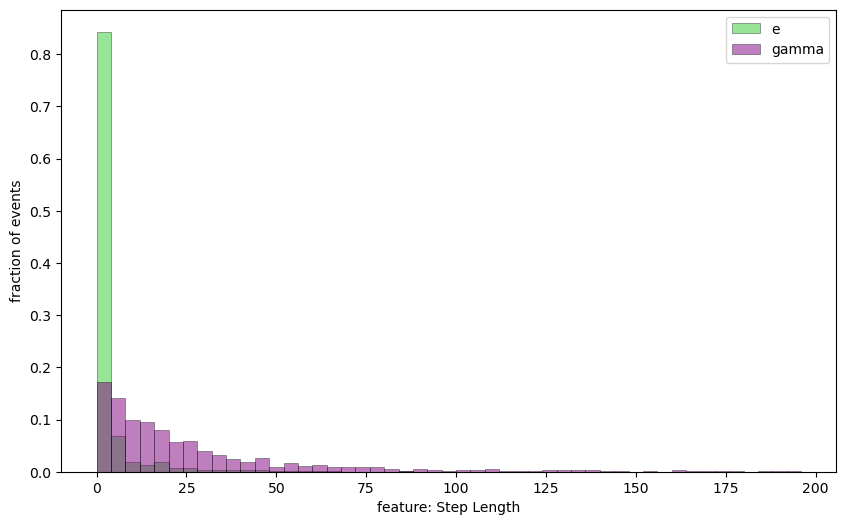

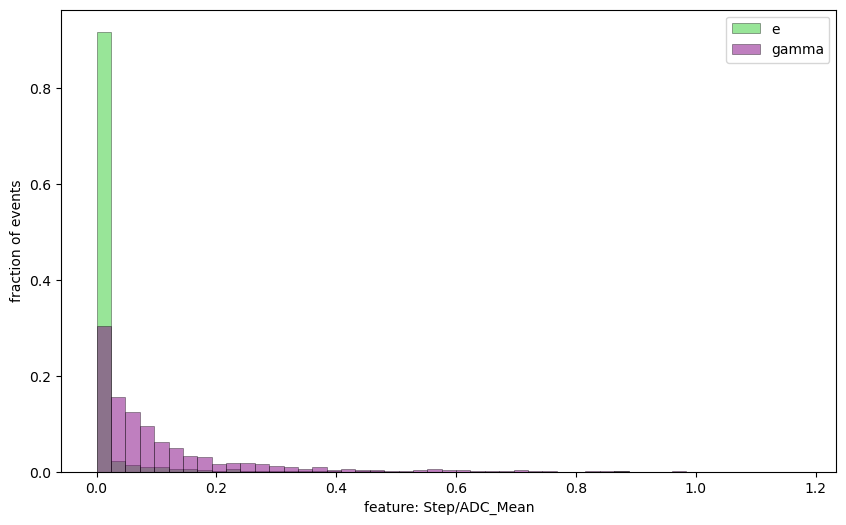

In [5]:
''' Plots '''

step_pdf = f.feature_histogram_2('Step Length', e_2, gamma_2, np.arange(0, 200, 4))

adcstp_pdf = f.feature_histogram_2('Step/ADC_Mean', e_adcstp, gamma_adcstp, np.arange(0, 1.2, 0.024))

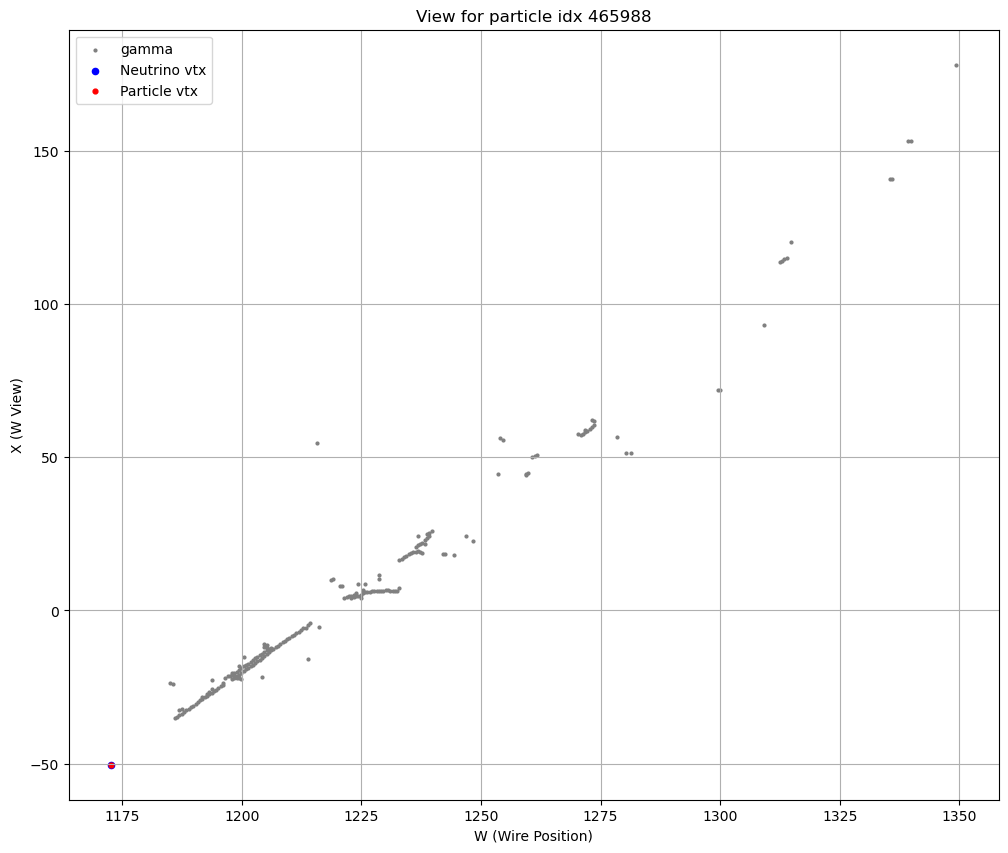

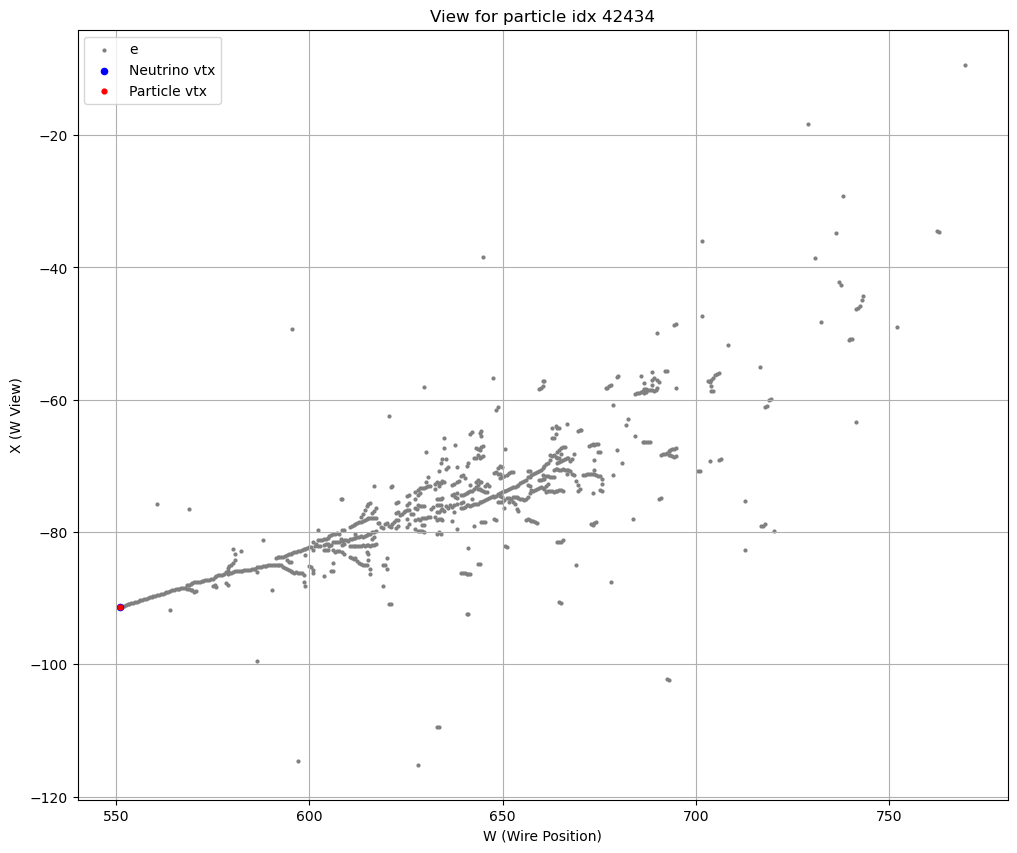

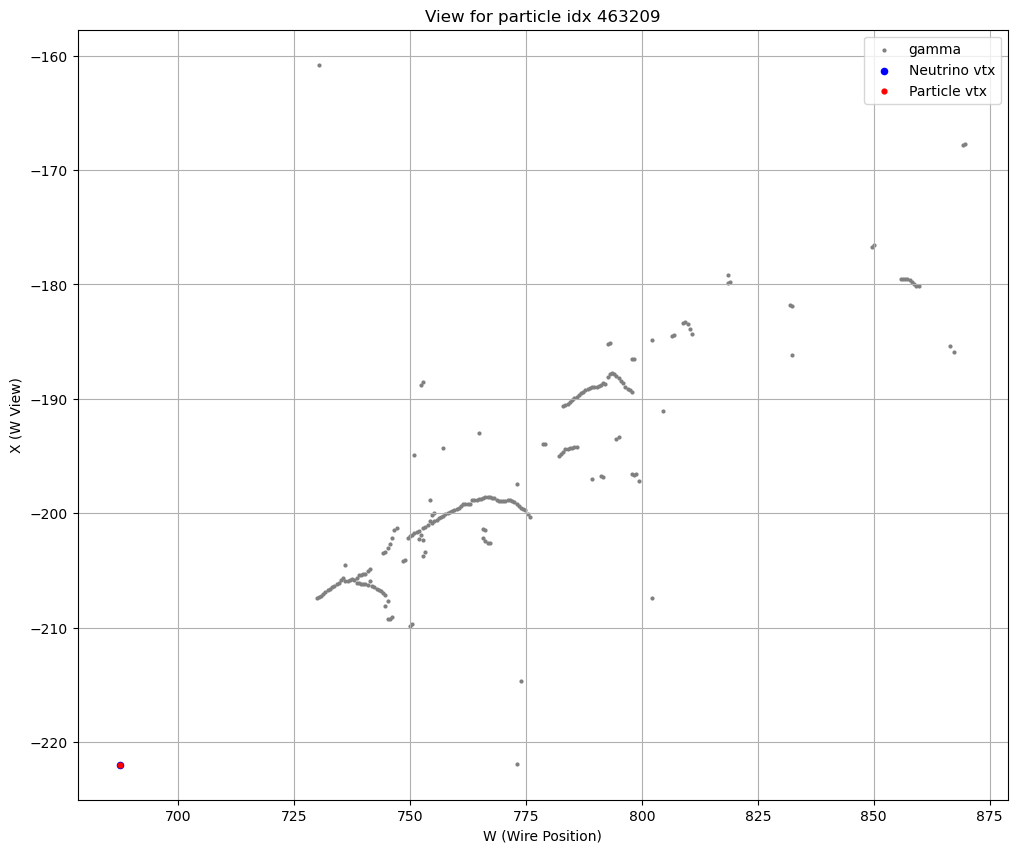

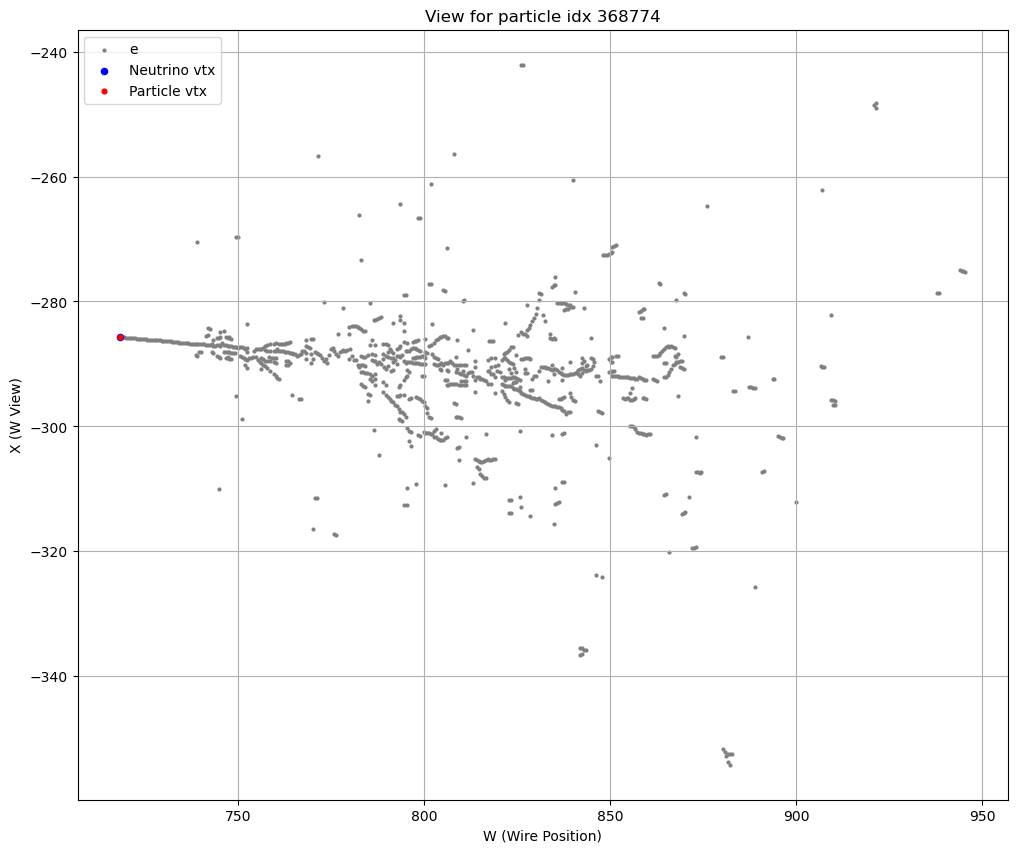

In [6]:
def plot_idx_vtx(events, event_idx):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    nu_vtx_w = events.neutrino_vtx_w[event_idx]
    nu_vtx_x = events.neutrino_vtx_x[event_idx]
    vtx_w = events.reco_particle_vtx_w[event_idx]
    vtx_x = events.reco_particle_vtx_x[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > 2:
        plt.figure(figsize = (12,10))
        if events.mc_pdg[event_idx] in [11, -11]:
            plt.scatter(w_hits, x_hits, c='grey', s=4, label='e')
        else: plt.scatter(w_hits, x_hits, c='grey', s=4, label='gamma')
        plt.scatter(nu_vtx_w, nu_vtx_x, c='b', s=20, label='Neutrino vtx')
        plt.scatter(vtx_w, vtx_x, c='r', s=12, label='Particle vtx')
        plt.title(f'View for particle idx {event_idx}')
        plt.ylabel('X (W View)')
        plt.xlabel('W (Wire Position)')
        plt.legend()
        plt.grid(True)
        plt.show()
    else: print('Less than 3 hits')

import random

# Get 10 random indices from testing_idx
random_indices = random.sample(testing_idx, 10)

# Iterate over the 10 random indices
for i in random_indices:
    if len(cheated_0.reco_hits_w[i]) > 15 and not cheated_0.is_true_track[i]:
        plot_idx_vtx(cheated_0, i)

In [32]:
''' Expanding to 3d '''
# will merely rewrite the functions to use 3d reconstructions. Will evaluate different functions later.

def step_length_3d(events, event_idx):
    # find all info for the feature
    x = events.reco_hits_3d_x[event_idx]
    y = events.reco_hits_3d_y[event_idx]
    z = events.reco_hits_3d_z[event_idx]
    
    x_vtx = events.neutrino_vtx_3d_x[event_idx]
    y_vtx = events.neutrino_vtx_3d_y[event_idx]
    z_vtx = events.neutrino_vtx_3d_z[event_idx]

    if len(x) < 3:
        print(f'Warning: Event {event_idx} has only {len(w_hits)} hits.')

    if events.is_true_track[event_idx]:
        print('Warning: Event is a true track')

    # finding step length
    x_step = min([abs(t - x_vtx) for t in x])
    y_step = min([abs(t - y_vtx) for t in y])
    z_step = min([abs(t - z_vtx) for t in z])
    step_length = np.sqrt(x_step**2 + y_step**2 + z_step**2)

    return step_length

def adc_step_prod_3d(events, event_idx):
    # find all info for the feature
    x = events.reco_hits_3d_x[event_idx]
    y = events.reco_hits_3d_y[event_idx]
    z = events.reco_hits_3d_z[event_idx]
    
    x_vtx = events.neutrino_vtx_3d_x[event_idx]
    y_vtx = events.neutrino_vtx_3d_y[event_idx]
    z_vtx = events.neutrino_vtx_3d_z[event_idx]
    
    adcs = np.array(events.reco_adcs_w[event_idx])
    adc_avg = np.mean(adcs)

    if len(x) < 3:
        print(f'Warning: Event {event_idx} has only {len(w_hits)} hits.')

    if events.is_true_track[event_idx]:
        print('Warning: Event is a true track')

    # finding step length
    x_step = min([abs(t - x_vtx) for t in x])
    y_step = min([abs(t - y_vtx) for t in y])
    z_step = min([abs(t - z_vtx) for t in z])
    step_length = np.sqrt(x_step**2 + y_step**2 + z_step**2)

    return step_length * adc_avg

def adc_step_div_3d(events, event_idx):
    # find all info for the feature
    x = events.reco_hits_3d_x[event_idx]
    y = events.reco_hits_3d_y[event_idx]
    z = events.reco_hits_3d_z[event_idx]
    
    x_vtx = events.neutrino_vtx_3d_x[event_idx]
    y_vtx = events.neutrino_vtx_3d_y[event_idx]
    z_vtx = events.neutrino_vtx_3d_z[event_idx]
    
    adcs = np.array(events.reco_adcs_w[event_idx])
    adc_avg = np.mean(adcs)

    if len(x) < 3:
        print(f'Warning: Event {event_idx} has only {len(w_hits)} hits.')

    if events.is_true_track[event_idx]:
        print('Warning: Event is a true track')

    # finding step length
    x_step = min([abs(t - x_vtx) for t in x])
    y_step = min([abs(t - y_vtx) for t in y])
    z_step = min([abs(t - z_vtx) for t in z])
    step_length = np.sqrt(x_step**2 + y_step**2 + z_step**2)

    return step_length / adc_avg

In [33]:
def step_arrays_3d(events, hits_cutoff):
    n = len(events.num_final_state_particles)

    e_step = []
    gamma_step = []
    total_showers = 0

    for i in testing_idx:
        if len(events.reco_hits_w[i]) > hits_cutoff and not events.is_true_track[i]:
            step = step_length_3d(events, i)
            total_showers += 1

            if events.mc_pdg[i] == 22:
                gamma_step.append(step)
            elif events.mc_pdg[i] in [-11, 11]:
                e_step.append(step)

    return e_step, gamma_step

e_3d, gamma_3d = step_arrays_3d(cheated_0, 15)

def adc_step_prod_arrays_3d(events, hits_cutoff):
    n = len(events.num_final_state_particles)

    e_step = []
    gamma_step = []
    total_showers = 0

    for i in testing_idx:
        if len(events.reco_hits_w[i]) > hits_cutoff and not events.is_true_track[i]:
            step = adc_step_prod_3d(events, i)
            total_showers += 1

            if events.mc_pdg[i] == 22:
                gamma_step.append(step)
            elif events.mc_pdg[i] in [-11, 11]:
                e_step.append(step)

    return e_step, gamma_step

e_adcstp_prod_3d, gamma_adcstp_prod_3d = adc_step_prod_arrays_3d(cheated_0, 15)


def adc_step_div_arrays_3d(events, hits_cutoff):
    n = len(events.num_final_state_particles)

    e_step = []
    gamma_step = []
    total_showers = 0

    for i in testing_idx:
        if len(events.reco_hits_w[i]) > hits_cutoff and not events.is_true_track[i]:
            step = adc_step_div_3d(events, i)
            total_showers += 1

            if events.mc_pdg[i] == 22:
                gamma_step.append(step)
            elif events.mc_pdg[i] in [-11, 11]:
                e_step.append(step)

    return e_step, gamma_step

e_adcstp_div_3d, gamma_adcstp_div_3d = adc_step_div_arrays_3d(cheated_0, 15)

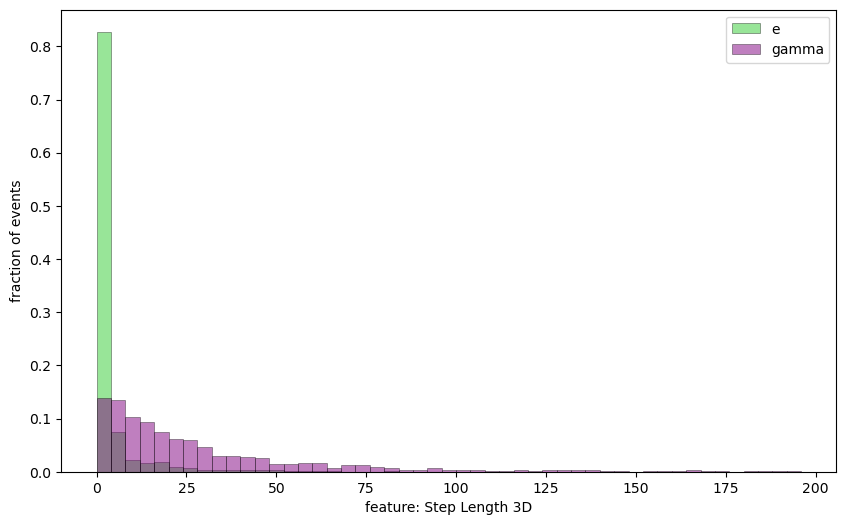

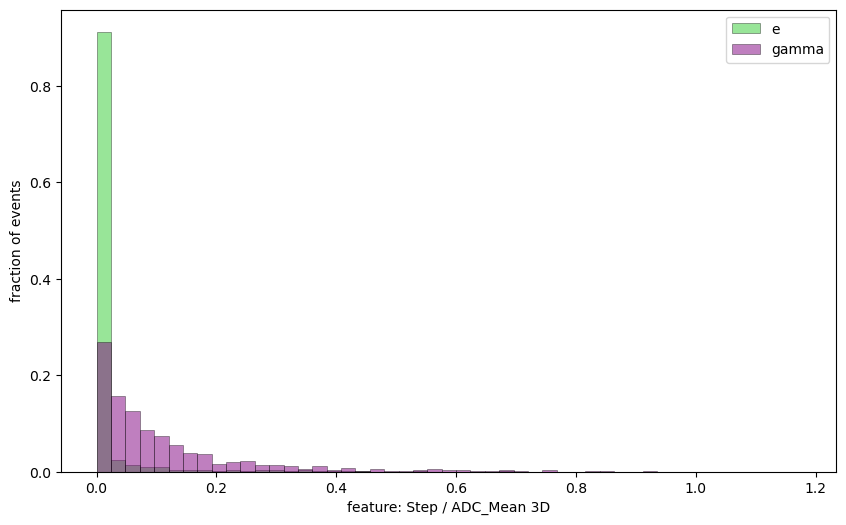

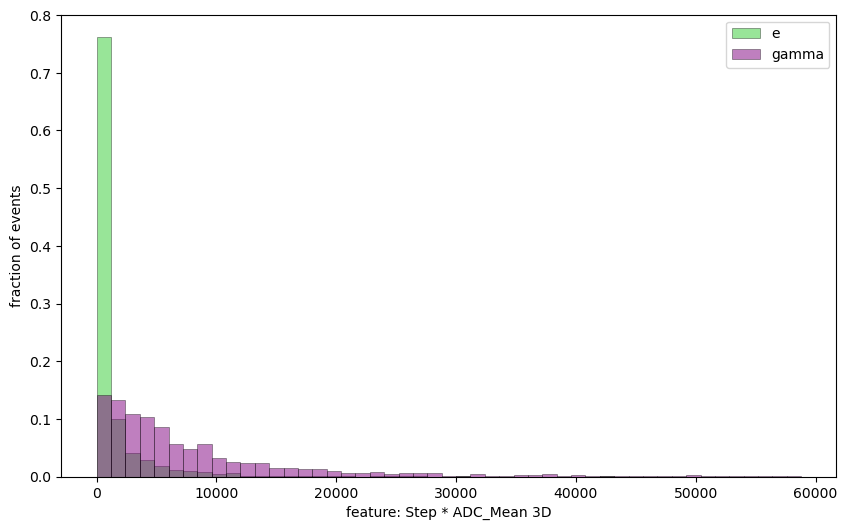

In [35]:
''' Plots '''

step_pdf_3d = f.feature_histogram_2('Step Length 3D', e_3d, gamma_3d, np.arange(0, 200, 4))
adcstp_div_pdf_3d = f.feature_histogram_2('Step / ADC_Mean 3D', e_adcstp_div_3d, gamma_adcstp_div_3d, np.arange(0, 1.2, 0.024))
adcstp_prod_pdf_3d = f.feature_histogram_2('Step * ADC_Mean 3D', e_adcstp_prod_3d, gamma_adcstp_prod_3d, np.arange(0, 60000, 1200))

In [21]:
step_length_arr = []
adc_step_arr = []

for i in testing_idx:
    if len(cheated_0.reco_hits_w[i]) > 15 and not cheated_0.is_true_track[i]:
        sl = step_length(cheated_0, i)
        adcstp = adc_step(cheated_0, i)
        
        step_length_arr.append(sl)
        adc_step_arr.append(adcstp)

correlation_matrix = np.corrcoef(step_length_arr, adc_step_arr)

# Extract the correlation coefficient
correlation_coefficient = correlation_matrix[0, 1]
print(f"Correlation coefficient: {correlation_coefficient}")

Correlation coefficient: 0.9412572790870385


In [38]:
step_length_arr_3d = []
adc_step_prod_arr_3d = []
adc_step_div_arr_3d = []

for i in testing_idx:
    if len(cheated_0.reco_hits_w[i]) > 15 and not cheated_0.is_true_track[i]:
        sl = step_length_3d(cheated_0, i)
        adcstp_prod = adc_step_prod_3d(cheated_0, i)
        adcstp_div = adc_step_div_3d(cheated_0, i)
        
        step_length_arr_3d.append(sl)
        adc_step_prod_arr_3d.append(adcstp_prod)
        adc_step_div_arr_3d.append(adcstp_div)

# Convert to NumPy arrays and stack them as rows for correlation computation
data = np.array([step_length_arr_3d, adc_step_prod_arr_3d, adc_step_div_arr_3d])

# Compute the correlation matrix
correlation_matrix = np.corrcoef(data)

# Print the matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
[[1.         0.85574319 0.93557935]
 [0.85574319 1.         0.67740366]
 [0.93557935 0.67740366 1.        ]]
